In [1]:
cd ..

/Users/igor.velikorechanin/Desktop/Masters/Thesis/GitHub PINN 4/trapezoidal_LF_model


/Users/igor.velikorechanin/Library/Python/3.9/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

from model.lf_model import LowFidelityPINN
from model.classic_pinn_model import ClassicalPINN
from utils.pde_utils import evaluate, get_exact_solution_parametric, evaluate_and_compare
from utils.data_utils import generate_synthetic_data, get_default_domain

from utils.config import PDE_CONFIGS, DOMAINS, TITLES

## Data Points Number Study

In [3]:
# Настройки
torch.manual_seed(42)
np.random.seed(42)

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

max_time = 90.0
noise_level = 0.05
n_data = 50
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)

### Functions

In [4]:
def ablation_n_data(pde_type, n_data_list=[20, 50, 100, 200, 500, 1000], 
                    # LF-PINN: Pretrain (PDE phase)
                    lf_pretrain_epochs=None,
                    lf_pretrain_time=None,
                    lf_pretrain_lr=0.005,
                    # LF-PINN: Finetune (Data phase)
                    lf_finetune_epochs=None,
                    lf_finetune_time=None,
                    lf_finetune_lr=0.001,
                    # LF-PINN: Модель
                    n_steps=10, 
                    n_iterations=2,
                    # Classical
                    cl_lr=0.001,
                    cl_lambda_data=10.0,
                    hidden_dim=6,
                    # Общее
                    n_collocation=30,
                    noise_level=0.05, 
                    seed=42,
                    verbose=True):
    """
    Исследование влияния количества данных на точность.
    
    LF-PINN: sequential подход (pretrain на PDE → finetune на Data)
    Classical: simultaneous подход, обучается РОВНО столько же времени, сколько LF-PINN
    
    Args:
        pde_type: тип уравнения
        n_data_list: список количества точек данных для тестирования
        
        # LF-PINN Pretrain
        lf_pretrain_epochs: кол-во эпох для LF pretrain
        lf_pretrain_time: время для LF pretrain (секунды)
        lf_pretrain_lr: learning rate для LF pretrain
        
        # LF-PINN Finetune
        lf_finetune_epochs: кол-во эпох для LF finetune
        lf_finetune_time: время для LF finetune (секунды)
        lf_finetune_lr: learning rate для LF finetune
        
        # LF-PINN Model
        n_steps: количество шагов LF-PINN
        n_iterations: количество итераций fixed-point
        
        # Classical (время = время LF-PINN)
        cl_lr: learning rate для Classical
        cl_lambda_data: вес data loss в Classical
        hidden_dim: размер скрытого слоя Classical PINN
        
        # Общее
        n_collocation: количество collocation points
        noise_level: уровень шума в данных
        seed: random seed
        verbose: выводить прогресс
    """
    from model.lf_model import LowFidelityPINN
    from model.classic_pinn_model import ClassicalPINN
    from utils.pde_utils import evaluate, get_exact_solution_parametric
    from utils.data_utils import generate_synthetic_data
    
    # Defaults для LF-PINN
    if lf_pretrain_epochs is None and lf_pretrain_time is None:
        lf_pretrain_epochs = 300
    if lf_finetune_epochs is None and lf_finetune_time is None:
        lf_finetune_epochs = 100
    
    domain = get_default_domain(pde_type)
    exact_sol = get_exact_solution_parametric(pde_type)
    
    results = {
        'n_data': n_data_list,
        'LF-PINN (no data)': {'l2re': [], 'rmse': [], 'time': []},
        'LF-PINN (with data)': {'l2re': [], 'rmse': [], 'time': []},
        'Classical (no data)': {'l2re': [], 'rmse': [], 'time': [], 'epochs': []},
        'Classical (with data)': {'l2re': [], 'rmse': [], 'time': [], 'epochs': []}
    }
    
    # ================================================================
    # Helper: LF-PINN одна фаза
    # ================================================================
    def train_lf_phase(model, domain, epochs, max_time, lr, n_collocation, 
                       data_points=None, data_values=None):
        """Обучает LF-PINN на PDE или на данных. Возвращает (epochs, time)."""
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
        start_time = time.time()
        epoch = 0
        
        while True:
            if epochs is not None and epoch >= epochs:
                break
            if max_time is not None and time.time() - start_time >= max_time:
                break
            
            optimizer.zero_grad()
            
            if data_points is None:
                loss, _ = model.total_loss(domain, n_collocation)
            else:
                x_data = data_points[:, 0:1]
                t_data = data_points[:, 1:2]
                u_pred = model.forward(x_data, t_data)
                loss = torch.mean((u_pred - data_values)**2)
            
            if torch.isnan(loss):
                break
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch += 1
        
        elapsed = time.time() - start_time
        return epoch, elapsed
    
    # ================================================================
    # Helper: Classical simultaneous (по времени)
    # ================================================================
    def train_classical_by_time(model, domain, max_time, lr, n_collocation,
                                data_points=None, data_values=None, lambda_data=10.0):
        """Обучает Classical PINN ровно max_time секунд. Возвращает epochs."""
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        start_time = time.time()
        epoch = 0
        
        x_min, x_max = domain['x']
        t_min, t_max = domain['t']
        device = next(model.parameters()).device
        
        while time.time() - start_time < max_time:
            optimizer.zero_grad()
            
            # PDE loss
            x_col = torch.rand(n_collocation, 1, device=device) * (x_max - x_min) + x_min
            t_col = torch.rand(n_collocation, 1, device=device) * (t_max - t_min) + t_min
            points = torch.cat([x_col, t_col], dim=1)
            pde_loss = model.pde_loss(points)
            bc_loss = model.boundary_loss(domain)
            
            loss = pde_loss + 10.0 * bc_loss
            
            # Data loss (если есть)
            if data_points is not None and data_values is not None:
                u_pred = model(data_points)
                data_loss = torch.mean((u_pred - data_values)**2)
                loss = loss + lambda_data * data_loss
            
            if torch.isnan(loss):
                break
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch += 1
        
        return epoch
    
    # ================================================================
    # BASELINE: LF-PINN без данных
    # ================================================================
    if verbose:
        lf_mode = f"{lf_pretrain_epochs} epochs" if lf_pretrain_epochs else f"{lf_pretrain_time}s"
        print(f"Training LF-PINN baseline (no data), {lf_mode}...")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    config = PDE_CONFIGS.get(pde_type, {'n_steps': 5, 'n_iterations': 2, 'lr': 0.001, 'theta': 0.5})
    model_lf_base = LowFidelityPINN(pde_type, n_steps=config['n_steps'], n_iterations=config['n_iterations'], lr=config['lr'], initial_theta=config['theta'])
    epochs_lf_base, time_lf_base = train_lf_phase(
        model_lf_base, domain, lf_pretrain_epochs, lf_pretrain_time, 
        lf_pretrain_lr, n_collocation
    )
    res_lf_base = evaluate(model_lf_base, domain, exact_solution=exact_sol)
    
    if verbose:
        print(f"  LF-PINN baseline: {epochs_lf_base} epochs, {time_lf_base:.2f}s, L2RE={res_lf_base['l2re']:.2e}")
    
    # ================================================================
    # BASELINE: Classical без данных (на время LF-PINN)
    # ================================================================
    if verbose:
        print(f"Training Classical baseline (no data) for {time_lf_base:.2f}s...")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    model_cl_base = ClassicalPINN(pde_type, hidden_dim=hidden_dim)
    epochs_cl_base = train_classical_by_time(
        model_cl_base, domain, time_lf_base, cl_lr, n_collocation
    )
    res_cl_base = evaluate(model_cl_base, domain, exact_solution=exact_sol)
    
    if verbose:
        print(f"  Classical baseline: {epochs_cl_base} epochs, {time_lf_base:.2f}s, L2RE={res_cl_base['l2re']:.2e}")
    
    # ================================================================
    # Для каждого n_data
    # ================================================================
    for n_data in n_data_list:
        if verbose:
            print(f"\n{'='*50}")
            print(f"n_data = {n_data}")
            print(f"{'='*50}")
        
        # Генерация данных
        data_points, data_values, _ = generate_synthetic_data(
            pde_type, domain, n_points=n_data, noise_level=noise_level, seed=seed
        )
        
        device = torch.device('cpu')
        data_points = data_points.to(device)
        data_values = data_values.to(device)
        
        # Baseline (одинаковый для всех n_data)
        results['LF-PINN (no data)']['l2re'].append(res_lf_base['l2re'])
        results['LF-PINN (no data)']['rmse'].append(res_lf_base['rmse'])
        results['LF-PINN (no data)']['time'].append(time_lf_base)
        results['Classical (no data)']['l2re'].append(res_cl_base['l2re'])
        results['Classical (no data)']['rmse'].append(res_cl_base['rmse'])
        results['Classical (no data)']['time'].append(time_lf_base)
        results['Classical (no data)']['epochs'].append(epochs_cl_base)
        
        # --- LF-PINN с данными (SEQUENTIAL) ---
        torch.manual_seed(seed)
        np.random.seed(seed)
        config = PDE_CONFIGS.get(pde_type, {'n_steps': 5, 'n_iterations': 2, 'lr': 0.001, 'theta': 0.5})
        model_lf = LowFidelityPINN(pde_type, n_steps=config['n_steps'], n_iterations=config['n_iterations'], lr=config['lr'], initial_theta=config['theta'])
        
        # Phase 1: Pretrain на PDE
        ep_pde_lf, time_pde_lf = train_lf_phase(
            model_lf, domain, lf_pretrain_epochs, lf_pretrain_time,
            lf_pretrain_lr, n_collocation
        )
        # Phase 2: Finetune на Data
        ep_data_lf, time_data_lf = train_lf_phase(
            model_lf, domain, lf_finetune_epochs, lf_finetune_time,
            lf_finetune_lr, n_collocation, data_points, data_values
        )
        
        total_time_lf = time_pde_lf + time_data_lf
        
        res_lf = evaluate(model_lf, domain, exact_solution=exact_sol)
        results['LF-PINN (with data)']['l2re'].append(res_lf['l2re'])
        results['LF-PINN (with data)']['rmse'].append(res_lf['rmse'])
        results['LF-PINN (with data)']['time'].append(total_time_lf)
        
        if verbose:
            imp_lf = (res_lf_base['l2re'] - res_lf['l2re']) / res_lf_base['l2re'] * 100
            print(f"  LF-PINN (sequential): L2RE={res_lf['l2re']:.2e} ({imp_lf:+.1f}%)")
            print(f"    pretrain: {ep_pde_lf} epochs, {time_pde_lf:.2f}s")
            print(f"    finetune: {ep_data_lf} epochs, {time_data_lf:.2f}s")
            print(f"    total: {total_time_lf:.2f}s")
        
        # --- Classical с данными (SIMULTANEOUS, на время LF-PINN) ---
        torch.manual_seed(seed)
        np.random.seed(seed)
        model_cl = ClassicalPINN(pde_type, hidden_dim=hidden_dim)
        
        if verbose:
            print(f"  Classical (simultaneous) training for {total_time_lf:.2f}s...")
        
        ep_cl = train_classical_by_time(
            model_cl, domain, total_time_lf, cl_lr, n_collocation, 
            data_points, data_values, cl_lambda_data
        )
        
        res_cl = evaluate(model_cl, domain, exact_solution=exact_sol)
        results['Classical (with data)']['l2re'].append(res_cl['l2re'])
        results['Classical (with data)']['rmse'].append(res_cl['rmse'])
        results['Classical (with data)']['time'].append(total_time_lf)
        results['Classical (with data)']['epochs'].append(ep_cl)
        
        if verbose:
            imp_cl = (res_cl_base['l2re'] - res_cl['l2re']) / res_cl_base['l2re'] * 100
            print(f"  Classical (simultaneous): L2RE={res_cl['l2re']:.2e} ({imp_cl:+.1f}%)")
            print(f"    epochs: {ep_cl}, time: {total_time_lf:.2f}s, λ_data={cl_lambda_data}")
    
    # Итоговая таблица
    if verbose:
        print(f"\n{'='*100}")
        print(f"SUMMARY: {pde_type.upper()} - N_DATA Ablation (equal time comparison)")
        print(f"LF-PINN: sequential | Classical: simultaneous (λ_data={cl_lambda_data})")
        print(f"{'='*100}")
        print(f"{'n_data':<8} {'LF (no data)':<14} {'LF (with)':<14} {'CL (no data)':<14} {'CL (with)':<14} {'Time':<10} {'CL epochs':<10}")
        print(f"{'-'*100}")
        
        for i, n_data in enumerate(n_data_list):
            print(f"{n_data:<8} "
                  f"{results['LF-PINN (no data)']['l2re'][i]:<14.2e} "
                  f"{results['LF-PINN (with data)']['l2re'][i]:<14.2e} "
                  f"{results['Classical (no data)']['l2re'][i]:<14.2e} "
                  f"{results['Classical (with data)']['l2re'][i]:<14.2e} "
                  f"{results['LF-PINN (with data)']['time'][i]:<10.2f} "
                  f"{results['Classical (with data)']['epochs'][i]:<10}")
        
        print(f"{'='*100}")
    
    return results


def plot_ablation_n_data(results, pde_title):
    """
    Визуализация ablation study по n_data.
    """
    n_data_list = results['n_data']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'{pde_title}: Effect of Data Quantity', fontsize=14, fontweight='bold')
    
    # L2RE
    ax1 = axes[0]
    ax1.axhline(results['LF-PINN (no data)']['l2re'][0], color='blue', 
                linestyle='--', label='LF-PINN (no data)', alpha=0.7)
    ax1.axhline(results['Classical (no data)']['l2re'][0], color='green', 
                linestyle='--', label='Classical (no data)', alpha=0.7)
    ax1.plot(n_data_list, results['LF-PINN (with data)']['l2re'], 
             'b-o', linewidth=2, markersize=8, label='LF-PINN (with data)')
    ax1.plot(n_data_list, results['Classical (with data)']['l2re'], 
             'g-s', linewidth=2, markersize=8, label='Classical (with data)')
    ax1.set_xlabel('Number of Data Points')
    ax1.set_ylabel('L2 Relative Error')
    ax1.set_title('L2RE vs Data Quantity')
    ax1.set_xscale('log')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # RMSE
    ax2 = axes[1]
    ax2.axhline(results['LF-PINN (no data)']['rmse'][0], color='blue', 
                linestyle='--', label='LF-PINN (no data)', alpha=0.7)
    ax2.axhline(results['Classical (no data)']['rmse'][0], color='green', 
                linestyle='--', label='Classical (no data)', alpha=0.7)
    ax2.plot(n_data_list, results['LF-PINN (with data)']['rmse'], 
             'b-o', linewidth=2, markersize=8, label='LF-PINN (with data)')
    ax2.plot(n_data_list, results['Classical (with data)']['rmse'], 
             'g-s', linewidth=2, markersize=8, label='Classical (with data)')
    ax2.set_xlabel('Number of Data Points')
    ax2.set_ylabel('RMSE')
    ax2.set_title('RMSE vs Data Quantity')
    ax2.set_xscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Таблица
    print(f"\n{'='*70}")
    print(f"{'n_data':<10} {'LF (no data)':<15} {'LF (with)':<15} {'CL (no data)':<15} {'CL (with)':<15}")
    print(f"{'-'*70}")
    for i, n in enumerate(n_data_list):
        print(f"{n:<10} "
              f"{results['LF-PINN (no data)']['l2re'][i]:<15.2e} "
              f"{results['LF-PINN (with data)']['l2re'][i]:<15.2e} "
              f"{results['Classical (no data)']['l2re'][i]:<15.2e} "
              f"{results['Classical (with data)']['l2re'][i]:<15.2e}")
    print(f"{'='*70}")

### Data Points Number Study - Heat Equation

Training LF-PINN baseline (no data), 200 epochs...

Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: heat | Max Steps: 4 | Params: 13
Iterations: 2 | LR: 0.05 | Max h: 0.1
Initial theta: 0.4

  LF-PINN baseline: 200 epochs, 28.56s, L2RE=1.54e-02
Training Classical baseline (no data) for 28.56s...
  Classical baseline: 48090 epochs, 28.56s, L2RE=3.27e-02

n_data = 20

Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: heat | Max Steps: 4 | Params: 13
Iterations: 2 | LR: 0.05 | Max h: 0.1
Initial theta: 0.4

  LF-PINN (sequential): L2RE=1.28e-02 (+17.3%)
    pretrain: 200 epochs, 28.12s
    finetune: 1000 epochs, 27.24s
    total: 55.36s
  Classical (simultaneous) training for 55.36s...
  Classical (simultaneous): L2RE=8.00e-03 (+75.5%)
    epochs: 85504, time: 55.36s, λ_data=10.0

n_data = 50

Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: heat | Max Steps: 4 | Params: 13
Iterations: 2 | LR: 0.05 | Max h: 0.1
Initial theta: 0.4

  LF-PINN (sequential): L2RE=2.36e-03 (+84.

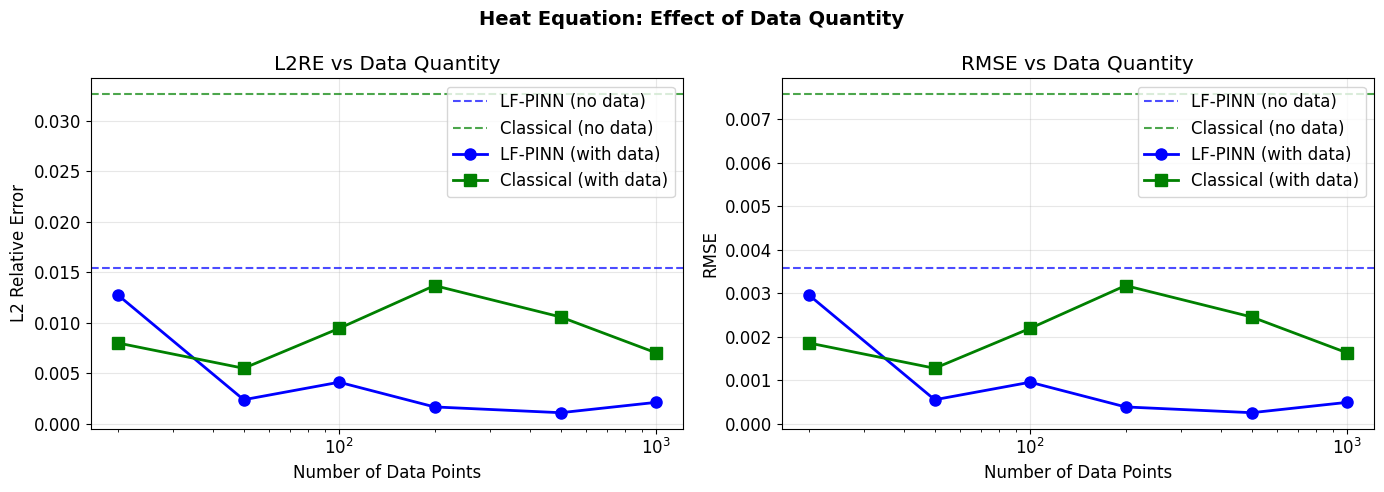


n_data     LF (no data)    LF (with)       CL (no data)    CL (with)      
----------------------------------------------------------------------
20         1.54e-02        1.28e-02        3.27e-02        8.00e-03       
50         1.54e-02        2.36e-03        3.27e-02        5.48e-03       
100        1.54e-02        4.10e-03        3.27e-02        9.44e-03       
200        1.54e-02        1.65e-03        3.27e-02        1.37e-02       
500        1.54e-02        1.08e-03        3.27e-02        1.06e-02       
1000       1.54e-02        2.10e-03        3.27e-02        7.01e-03       


In [5]:
# Heat equation
results_heat = ablation_n_data('heat', lf_pretrain_epochs=200, lf_finetune_epochs = 1000, lf_pretrain_lr=0.05, lf_finetune_lr=0.0001)
plot_ablation_n_data(results_heat, 'Heat Equation')

### Data Points Number Study - Burgers Equation

Training LF-PINN baseline (no data), 200 epochs...

Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: burgers | Max Steps: 2 | Params: 13
Iterations: 2 | LR: 0.05 | Max h: 0.1
Initial theta: 0.25



/Users/igor.velikorechanin/Desktop/Masters/Thesis/GitHub PINN 4/trapezoidal_LF_model/utils/pde_utils.py:448: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  phi_x, _ = quad(integrand_phi_x, limit_low, limit_high,


  LF-PINN baseline: 200 epochs, 77.37s, L2RE=3.02e-01
Training Classical baseline (no data) for 77.37s...
  Classical baseline: 130037 epochs, 77.37s, L2RE=2.09e-01

n_data = 20

Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: burgers | Max Steps: 2 | Params: 13
Iterations: 2 | LR: 0.05 | Max h: 0.1
Initial theta: 0.25

  LF-PINN (sequential): L2RE=3.05e-01 (-0.9%)
    pretrain: 200 epochs, 75.45s
    finetune: 1000 epochs, 32.12s
    total: 107.56s
  Classical (simultaneous) training for 107.56s...
  Classical (simultaneous): L2RE=1.81e-01 (+13.2%)
    epochs: 162270, time: 107.56s, λ_data=10.0

n_data = 50

Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: burgers | Max Steps: 2 | Params: 13
Iterations: 2 | LR: 0.05 | Max h: 0.1
Initial theta: 0.25

  LF-PINN (sequential): L2RE=3.03e-01 (-0.2%)
    pretrain: 200 epochs, 72.16s
    finetune: 1000 epochs, 32.41s
    total: 104.57s
  Classical (simultaneous) training for 104.57s...
  Classical (simultaneous): L2RE=1.41e-01 (+3

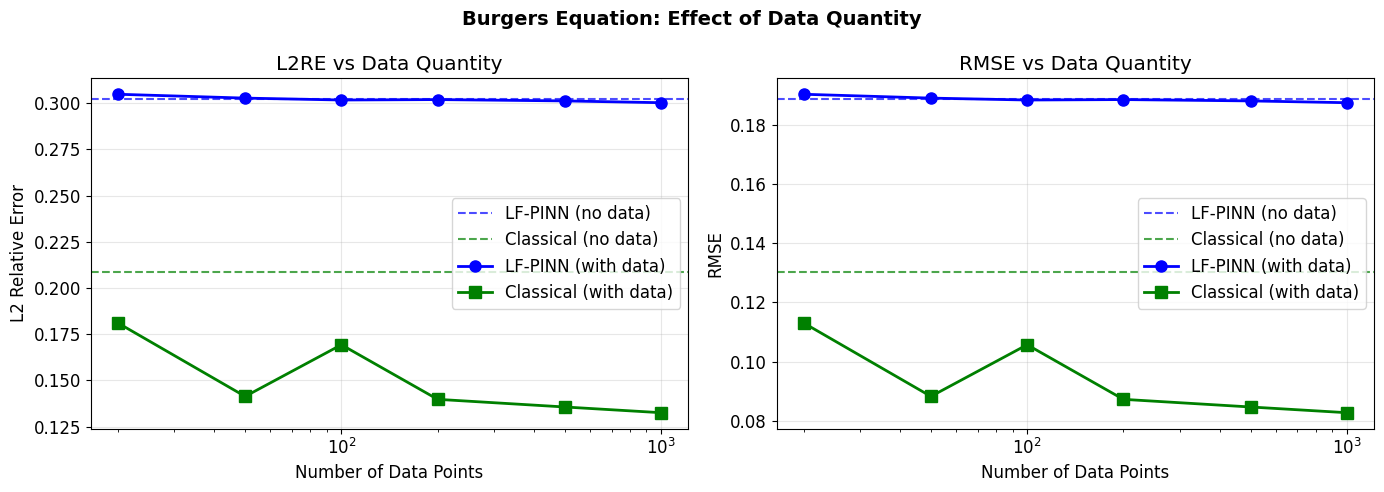


n_data     LF (no data)    LF (with)       CL (no data)    CL (with)      
----------------------------------------------------------------------
20         3.02e-01        3.05e-01        2.09e-01        1.81e-01       
50         3.02e-01        3.03e-01        2.09e-01        1.41e-01       
100        3.02e-01        3.02e-01        2.09e-01        1.69e-01       
200        3.02e-01        3.02e-01        2.09e-01        1.40e-01       
500        3.02e-01        3.01e-01        2.09e-01        1.36e-01       
1000       3.02e-01        3.00e-01        2.09e-01        1.33e-01       


In [7]:
# Burgers
results_burgers = ablation_n_data('burgers', lf_pretrain_epochs=200, lf_finetune_epochs = 1000, n_steps=2, n_iterations=2, lf_pretrain_lr=0.05, lf_finetune_lr=0.0001)
plot_ablation_n_data(results_burgers, 'Burgers Equation')

### Data Points Number Study - Wave Equation

Training LF-PINN baseline (no data), 100 epochs...

Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: wave | Max Steps: 3 | Params: 13
Iterations: 3 | LR: 0.001 | Max h: 0.1
Initial theta: 0.5

  LF-PINN baseline: 100 epochs, 65.93s, L2RE=3.11e-02
Training Classical baseline (no data) for 65.93s...
  Classical baseline: 77374 epochs, 65.93s, L2RE=5.76e-03

n_data = 20

Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: wave | Max Steps: 3 | Params: 13
Iterations: 3 | LR: 0.001 | Max h: 0.1
Initial theta: 0.5

  LF-PINN (sequential): L2RE=3.34e-02 (-7.4%)
    pretrain: 100 epochs, 64.99s
    finetune: 1000 epochs, 78.90s
    total: 143.89s
  Classical (simultaneous) training for 143.89s...
  Classical (simultaneous): L2RE=1.14e-02 (-98.1%)
    epochs: 157285, time: 143.89s, λ_data=10.0

n_data = 50

Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: wave | Max Steps: 3 | Params: 13
Iterations: 3 | LR: 0.001 | Max h: 0.1
Initial theta: 0.5

  LF-PINN (sequential): L2RE=3.24e-02

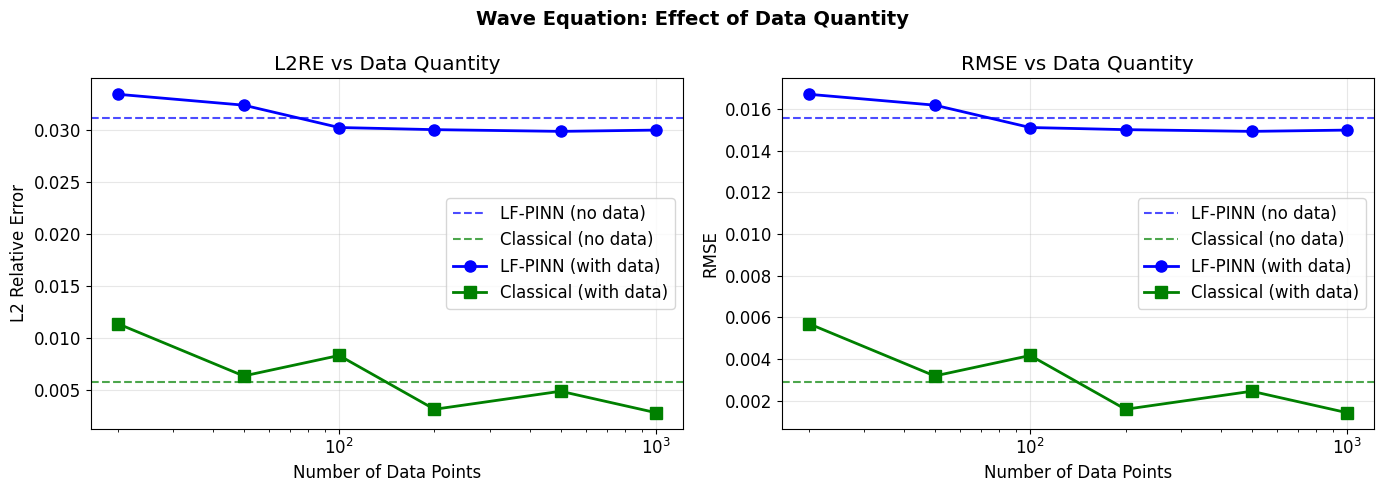


n_data     LF (no data)    LF (with)       CL (no data)    CL (with)      
----------------------------------------------------------------------
20         3.11e-02        3.34e-02        5.76e-03        1.14e-02       
50         3.11e-02        3.24e-02        5.76e-03        6.38e-03       
100        3.11e-02        3.02e-02        5.76e-03        8.34e-03       
200        3.11e-02        3.00e-02        5.76e-03        3.17e-03       
500        3.11e-02        2.99e-02        5.76e-03        4.91e-03       
1000       3.11e-02        3.00e-02        5.76e-03        2.84e-03       


In [5]:
results_wave = ablation_n_data('wave', lf_pretrain_epochs=100, lf_finetune_epochs = 1000, n_steps=3, n_iterations=3, lf_pretrain_lr=0.001, lf_finetune_lr=0.0001)
plot_ablation_n_data(results_wave, 'Wave Equation')

### Data Points Number Study - Reaction-Diffusion Equation

Training LF-PINN baseline (no data), 120 epochs...

Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: reaction_diffusion | Max Steps: 2 | Params: 13
Iterations: 2 | LR: 0.05 | Max h: 0.1
Initial theta: 0.3

  LF-PINN baseline: 120 epochs, 60.86s, L2RE=1.36e-01
Training Classical baseline (no data) for 60.86s...
  Classical baseline: 92103 epochs, 60.86s, L2RE=1.36e-01

n_data = 20

Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: reaction_diffusion | Max Steps: 2 | Params: 13
Iterations: 2 | LR: 0.05 | Max h: 0.1
Initial theta: 0.3

  LF-PINN (sequential): L2RE=1.36e-01 (+0.0%)
    pretrain: 120 epochs, 59.52s
    finetune: 1000 epochs, 41.03s
    total: 100.55s
  Classical (simultaneous) training for 100.55s...
  Classical (simultaneous): L2RE=6.22e-02 (+54.3%)
    epochs: 137440, time: 100.55s, λ_data=10.0

n_data = 50

Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: reaction_diffusion | Max Steps: 2 | Params: 13
Iterations: 2 | LR: 0.05 | Max h: 0.1
Initial theta: 0.3

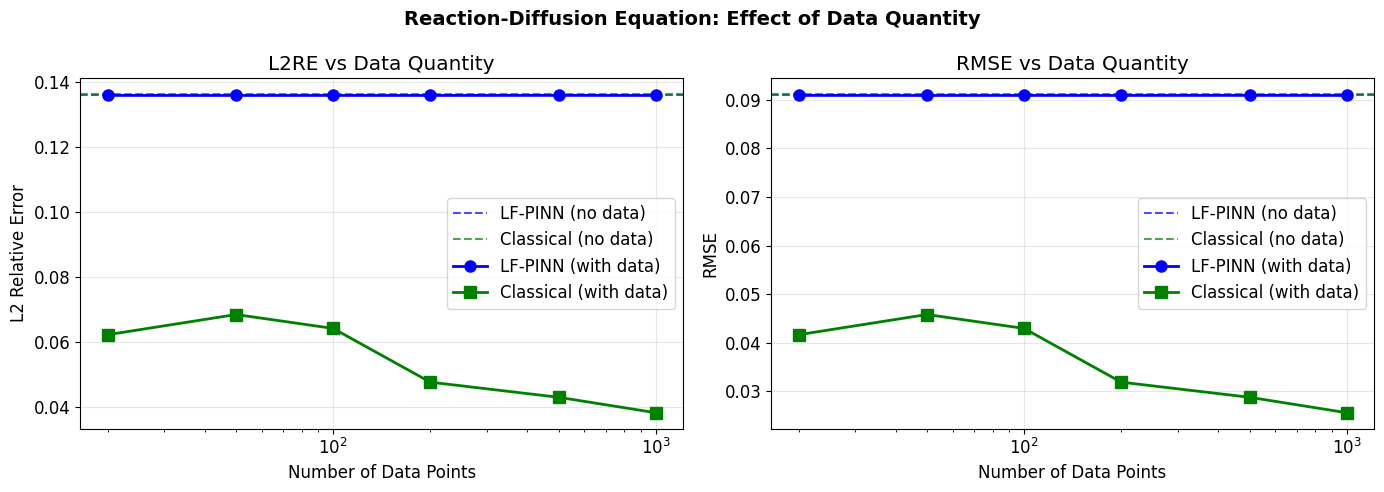


n_data     LF (no data)    LF (with)       CL (no data)    CL (with)      
----------------------------------------------------------------------
20         1.36e-01        1.36e-01        1.36e-01        6.22e-02       
50         1.36e-01        1.36e-01        1.36e-01        6.84e-02       
100        1.36e-01        1.36e-01        1.36e-01        6.42e-02       
200        1.36e-01        1.36e-01        1.36e-01        4.76e-02       
500        1.36e-01        1.36e-01        1.36e-01        4.30e-02       
1000       1.36e-01        1.36e-01        1.36e-01        3.82e-02       


In [8]:
results_rd = ablation_n_data('reaction_diffusion', lf_pretrain_epochs=120, lf_finetune_epochs = 1000, n_steps=2, n_iterations=2, lf_pretrain_lr=0.05, lf_finetune_lr=0.0001)
plot_ablation_n_data(results_rd, 'Reaction-Diffusion Equation')